# Predict if pairs of questions from Quora contain two questions with the same semantics. 
Dataset: https://www.kaggle.com/c/quora-question-pairs/data

## Read the data

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.columns.values

array(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'],
      dtype=object)

In [4]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [5]:
len(df)

404290

Example of two questions which share the same semantics.

In [6]:
df['question1'][7], df['question2'][7]

('How can I be a good geologist?', 'What should I do to be a great geologist?')

## Vectorize the dataset

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Let's consider only the top 10000 words appearing in the questions.

In [10]:
maxWords = 10000

We need to decide what's the maximum length of the questions that we shall consider.

Let's get the sizes of each question.

In [11]:
sizeQuestionOne = df['question1'].map(lambda x: len(str(x).split(" ")))
sizeQuestionTwo = df['question2'].map(lambda x: len(str(x).split(" ")))

Plot them in a histogram

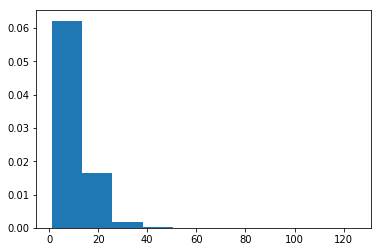

In [12]:
plt.hist(sizeQuestionOne, normed=True, bins=10);

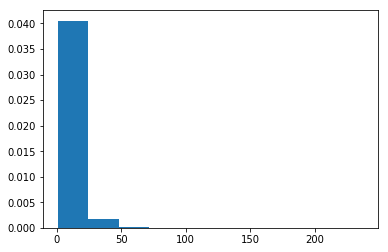

In [13]:
plt.hist(sizeQuestionTwo, normed=True, bins=10);

We see that most values are below 100. So 100 seems to be a a reasonable length.

In [14]:
maxQuestionSize = 100

In [15]:
questionOne = df['question1'].astype(str).tolist()
questionTwo = df['question2'].astype(str).tolist()

**Tokenize the questions**

In [16]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(questionOne + questionTwo)
sequenceOne = tokenizer.texts_to_sequences(questionOne)
sequenceTwo = tokenizer.texts_to_sequences(questionTwo)

**Pad the questions to make sure they are all of length 100**

In [17]:
dataOne = pad_sequences(sequenceOne, maxlen=maxQuestionSize)
dataTwo = pad_sequences(sequenceTwo, maxlen=maxQuestionSize)

**Process the labels**

In [18]:
labels = np.array(df['is_duplicate'].tolist())

In [19]:
dataOne.shape, dataTwo.shape

((404290, 100), (404290, 100))

In [20]:
labels.shape

(404290,)

## Split into training, validation and test set

In [21]:
trainingSetSize = 10000
validationSetSize = 1000

In [22]:
trainingSetOne = dataOne[:trainingSetSize]
trainingSetTwo = dataTwo[:trainingSetSize]
trainingLabels = labels[:trainingSetSize]

validationSetOne = dataOne[trainingSetSize: trainingSetSize + validationSetSize]
validationSetTwo = dataTwo[trainingSetSize: trainingSetSize + validationSetSize]
validationLabels = labels[trainingSetSize: trainingSetSize + validationSetSize]

testSetOne = dataOne[trainingSetSize + validationSetSize:300000]
testSetTwo = dataTwo[trainingSetSize + validationSetSize:300000]
testLabels = labels[trainingSetSize + validationSetSize:300000]

## Build the model
We will use a Siamese network in order to compute the similarity between the two questions.

A Siamese network consists of two identical neural networks or layers, each taking one of the two input questions. The last layers of the two networks are then fed to a contrastive loss function , which calculates the similarity between the two questions.

This is shown in the figure below.

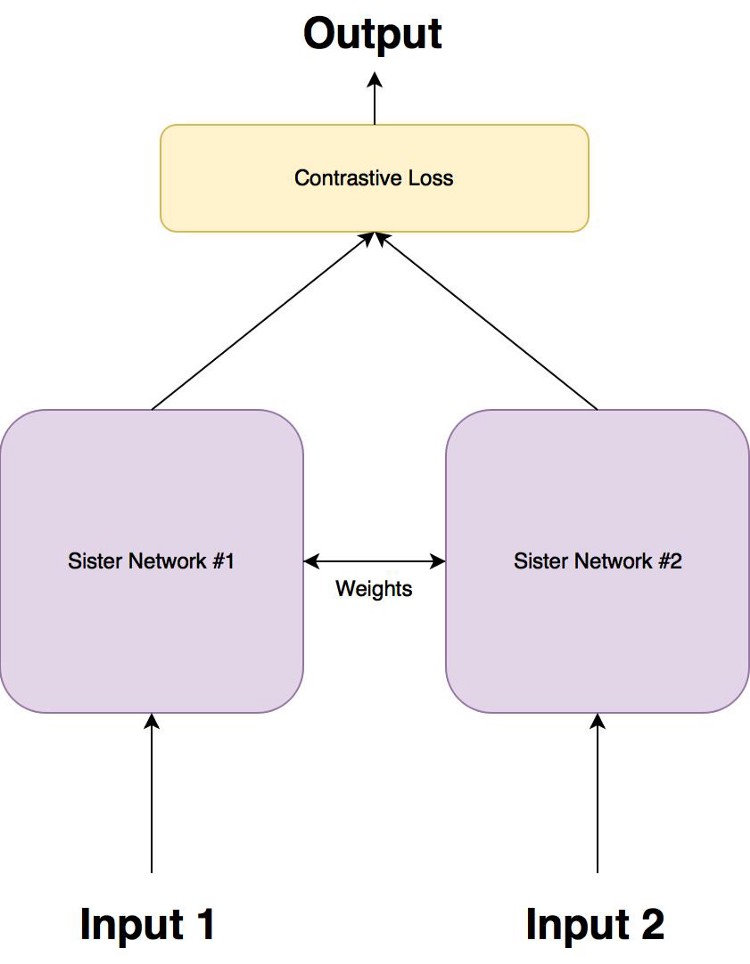

In [23]:
Image("siameseNN.jpeg", width=400, height=300)

### Contrastive Loss Function
Since Keras does not have an inbuilt contrastive loss function, we can define our own. 

Reference: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

In [24]:
import keras.backend as K

In [25]:
def contrastiveLoss(y_true, y_pred):
    margin = 1
    return (K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0))))

### Custom Accuracy Function

The keras default accuracy function expects if the label is 1, then the output label should be 1.

However, in our case if the label is 1, the output should be low (near zero).

In [26]:
def customAccuracy(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1)

### Manhattan Distance

In [27]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

### Model

In [28]:
from keras import layers
from keras import activations
from keras import losses
from keras import optimizers
from keras import metrics
from keras import Input
from keras.models import Model

**Create the embedding layer**

In [29]:
embeddingDimensions = 100
embeddingLayer = layers.Embedding(embeddingDimensions, maxQuestionSize)

In [30]:
leftInput = Input(shape=(maxQuestionSize,), dtype='int32', name="questionOne")
rightInput = Input(shape=(maxQuestionSize,), dtype='int32', name="questionTwo")

In [31]:
embeddedQuestionOne = embeddingLayer(leftInput)
embeddedQuestionTwo = embeddingLayer(rightInput)

In [33]:
lstm = layers.Bidirectional(layers.LSTM(64))

**Reuse the same LSTM layer for both the questions, thus sharing the same layer**

In [34]:
leftOutput = lstm(embeddedQuestionOne)
rightOutput = lstm(embeddedQuestionTwo)

**Builds the classifier on top**

In [35]:
# Calculates the distance as defined by the MaLSTM model
distance = layers.merge([leftOutput, rightOutput], 
                        mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), 
                        output_shape=lambda x: (x[0][0], 1))

#merged = layers.concatenate([leftOutput, rightOutput], axis=-1)
predictions = layers.Dense(1, activation=activations.sigmoid)(distance)

c:\python35\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
c:\python35\lib\site-packages\keras\legacy\layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [36]:
model = Model([leftInput, rightInput], predictions)

In [37]:
model.compile(optimizer=optimizers.Adam(),
             loss=losses.MSE,
             metrics=[metrics.binary_accuracy])

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questionOne (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
questionTwo (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 100)     10000       questionOne[0][0]                
                                                                 questionTwo[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 128)          84480       embedding_1[0][0]                
          

In [39]:
history = model.fit([trainingSetOne, trainingSetTwo], 
                    trainingLabels, 
                    epochs=10, 
                    batch_size=128,
                    validation_data=([validationSetOne, validationSetTwo], validationLabels))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 52s 5ms/step - loss: 0.2482 - binary_accuracy: 0.5814 - val_loss: 0.2458 - val_binary_accuracy: 0.6260
Epoch 2/10
10000/10000 [==============================] - 48s 5ms/step - loss: 0.2439 - binary_accuracy: 0.6289 - val_loss: 0.2425 - val_binary_accuracy: 0.6260
Epoch 3/10
10000/10000 [==============================] - 48s 5ms/step - loss: 0.2409 - binary_accuracy: 0.6289 - val_loss: 0.2399 - val_binary_accuracy: 0.6260
Epoch 4/10
10000/10000 [==============================] - 48s 5ms/step - loss: 0.2386 - binary_accuracy: 0.6289 - val_loss: 0.2381 - val_binary_accuracy: 0.6260
Epoch 5/10
10000/10000 [==============================] - 48s 5ms/step - loss: 0.2369 - binary_accuracy: 0.6289 - val_loss: 0.2367 - val_binary_accuracy: 0.6260
Epoch 6/10
10000/10000 [==============================] - 48s 5ms/step - loss: 0.2353 - binary_accuracy: 0.6289 - val_loss: 0.2353 - val_binary_ac

In [40]:
history.history.keys()

dict_keys(['val_binary_accuracy', 'val_loss', 'binary_accuracy', 'loss'])

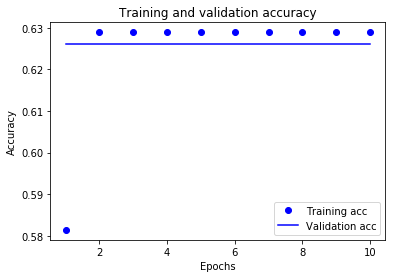

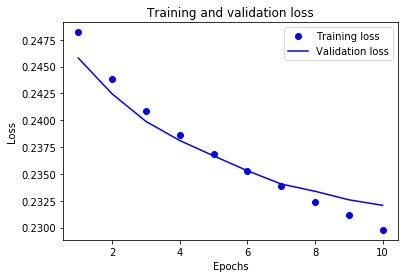

In [41]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();